In [13]:
import pandas as pd
import numpy as np
import traceback
import datetime
import sys
import locale
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [14]:
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (17,6.5)

# Importar Datasets

In [15]:
def import_data():
    path = "Datasets/"#diretório dos datasets
    
    # --------- as linhas abaixo servem para gerar o nome dos arquivos automaticamente
    prefix = "ABONOP_"#prefixo comun a todos os arquivos
    months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']#meses presentes
    years = ["2017", "2018", "2019", "2020"]#anos presentes
    ext = ".csv"#extensão dos arquivos
    
    # ------------------------
    
    columns = ["Nome", "CPF", "Descrição do cargo emprego", "Nível de Escolaridade", "Denominação do órgão de atuação",
              "UF da UPAG de vinculação", "Denominação unidade organizacional", "UF da Residência",
              "Cidade da residência", "Situação servidor", "Quantidade de anos no Serviço público",
              "Quantidade de meses no Serviço público","Ano/Mês inicial DO ABONO DE PERMANENCIA","VAL"] #colunas presentes
    
    date_columns = ["Ano/Mês inicial DO ABONO DE PERMANENCIA"]#colunas que devem ser transformadas em datas, porém no dataset estão como inteiros
    float_columns = {"VAL":np.float64}#coluna númerica
    
    datasets = []#esta variavel vai ser usada como uma lista de DataFrames importados
    sep = ";"#separador utilizado nos arquivos
    decimal = "."#valores decimais são separados por virgula
    try:
        name = ""
        for i in years:# esse loop vai importar os datasets ano a ano
            for j in months:# esse loop vai importar os datasets mês a mês
                name = path + prefix + j + i + ext# concatena as informações do arquivo para formar seu nome

                df = pd.read_csv(name, sep =sep, low_memory = False,
                                names = columns, header = 0,
                                #warn_bad_lines = True
                                encoding = 'cp1252', index_col=False)#ver documentação do pandas
                date = datetime.date(int(i), int(j), 1)#cria uma data do tipo 1/j/i
                df["DATE"] = [date for k in range(df.shape[0])]#adiciona uma coluna com a data
                datasets.append(df)
    except Exception as e:#ocorreu algum exceção
        traceback.print_exc()#printa a pilha de execução
        print("Erro na planilha: {}".format(name))#printa a plainlha que ocorreu o erro
    finally:
        if len(datasets) > 0:
            datasets = pd.concat(datasets)#concatena os datasets que foram importados com sucesso
            #datasets.drop_duplicates(subset = columns, inplace = True)#tira as colunas duplicadas, não considera a coluna DATE
            
            datasets.reset_index(inplace = True)
            datasets.drop(columns = ["index"], inplace = True)
            
        return datasets

In [16]:
def import_dataset(name, sep = ",", columns = []):
    df = pd.read_csv(name, sep =sep, #low_memory = False,
                    names = columns, header = 0,
                    #warn_bad_lines = True
                   index_col=False)#ver documentação do pandas
    return df

In [17]:
abono_dataset = import_data()

In [18]:
cidades_dataset = import_dataset("Datasets/municipios.csv", sep = ";", columns = ["ConcatUF+Mun", "IBGE", "IBGE7", "UF", "Município", 
                                               "Região", "População 2010", "Porte", "Capital"])

C:\Users\samue\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


# Retirar espaços em branco em excesso e alguns ajustes

In [19]:
def clean_spaces(df, text_columns, number_columns):
    #retira os espaços em branco e coloca todos os caracteres em caixa baixa
    new_df = df.applymap(
        lambda x: " ".join( x.split() ).lower() if isinstance(x, str) else x, 
        na_action = 'ignore')
    del df
    #troca todas as ',' por '.'
    new_df[number_columns] = new_df[number_columns].applymap(
        lambda x: ".".join(x.split(",")) if isinstance(x, str) else x, 
        na_action = 'ignore')
    
    return new_df

In [21]:
text_columns = ["Nome", "CPF", "Descrição do cargo emprego", "Nível de Escolaridade", "Denominação do órgão de atuação",
              "UF da UPAG de vinculação", "Denominação unidade organizacional", "UF da Residência",
              "Cidade da residência", "Situação servidor"]
number_columns = ["Quantidade de anos no Serviço público","Quantidade de meses no Serviço público",
                  "Ano/Mês inicial DO ABONO DE PERMANENCIA","VAL"]
abono_dataset = clean_spaces(abono_dataset, text_columns, number_columns)

In [22]:
dtypes = {
    "Quantidade de anos no Serviço público": int,
    "Quantidade de meses no Serviço público": int,
    "VAL": np.float64
}
abono_dataset = abono_dataset.astype(dtypes)

# Corrigir coluna Cidade da residência

In [23]:
def distancia_hamming(string1, string2):
    """
    Calcula a distancia de hamming entre as strings de entrada
    """
    #código de https://stackoverflow.com/questions/54172831/hamming-distance-between-two-strings-in-python
    return sum(c1 != c2 for c1, c2 in zip(string1, string2))

In [24]:
def corrige_cidade(cidades_do_estado , cidade):
    """
    Essa função corrige a cidade dada por uma na lista cidades_do_estado
    A função de distancia de hamming é utilizada como critério para escolha
    O algoritmo escolhe o elemento com menor distância de hamming da lista cidades_do_estado
    com cidade
    """
    if cidade in cidades_do_estado:#verifica se a cidade já existe na lista
        return cidade
    else:#se não ela vai ser processada
        cid_min = ""#inicializa a cidade com distancia de hamming minima
        distancia_min = 999999#inicializa a minima distancia de hamming encontrada
        for cid in cidades_do_estado:#percorre todas as cidades do estado
            distancia = distancia_hamming(cid, cidade)#calcula a distancia entre a cidade atual e a cidade informada
            if distancia < distancia_min:
                #se essa distancia for menor que a minima até agora
                #então é feita uma substituição
                cid_min = cid
                distancia_min = distancia
        return cid_min#retorna a cidade com distancia minima encontrada

In [25]:
estados = set(cidades_dataset["UF"].to_list())
cidades_por_estado = dict()
for estado in estados:#organiza um diciionário de cidades por estado
    cds = cidades_dataset.loc[cidades_dataset["UF"] == estado]["Município"].to_list()
    cidades_por_estado[estado] = list(map(lambda x: x.lower(), cds))

In [26]:
#realiza correção das cidades
idx_cidade = 9#indice da coluna cidade
idx_uf = 8#indice da coluna uf
mudancas = []#esse array vai salvando as correçoes de cada linha
cache = dict()#dicionario de cache para poupar processamento
for row in abono_dataset.itertuples():
    uf = row[idx_uf].upper()#transforma em caixa alta pois as chaves em cidades_por_estado estão em caixa alta, 
    if uf in cidades_por_estado:# se a uf da linha existe no diciionario de cidades_por_estado
        
        cd_desconhecida = row[idx_cidade]
        cidade = ""
        if cd_desconhecida in cache:#verifica se a cidade já foi processada
            cidade = cache[cd_desconhecida]#recupera o resultado
        else:#se não foi
            cidades = cidades_por_estado[uf]#obtem as cidades do estado daquela linha
            cidade = corrige_cidade(cidades, cd_desconhecida)#corrige a cidade
            cache[cd_desconhecida] = cidade#salva o resultado na cache
        mudancas.append(cidade)#adiciona na lista de mudancas
    else:# se não existe não faz nenhum processamento
        mudancas.append(row[idx_cidade])
        #print(row[idx_cidade], cidade)
        
abono_dataset["Cidade da residência"] = pd.Series(data = mudancas)

# Corrigir coluna Nível de Escolaridade

In [27]:
#realiza correção do nível de escolaridade
idx_escolaridade = 4#indice da coluna Nível de Escolaridade

mud_escolaridade = {
    "segundo grau incompleto": "ensino medio incompleto",
    "4a. serie do primeiro grau completa": "ensino fundamental incompleto",
    "primeiro grau incomp.-ate a 4a.serie incomp.": "ensino fundamental incompleto"
}
mudancas =[]
for row in abono_dataset.itertuples():
    if row[idx_escolaridade] in mud_escolaridade:
        mudancas.append(mud_escolaridade[row[idx_escolaridade]])
    else:
         mudancas.append(row[idx_escolaridade])
abono_dataset["Nível de Escolaridade"] = pd.Series(data = mudancas)

# Corrigir coluna Ano/Mês inicial DO ABONO DE PERMANENCIA	

In [28]:
#converte a coluna para datetime.date

In [29]:
def converte_int_date(df, coluna):
    """Transforma a coluna de inteiros em datas"""
    df[coluna] = df[coluna].apply(lambda x: datetime.date(x//100, x%100, 1) if isinstance(x, int) else x)#coloca o dia como 1 por padrão

In [30]:
converte_int_date(abono_dataset, "Ano/Mês inicial DO ABONO DE PERMANENCIA")

# Codificação de campos strings para inteiros

### UF da Residência

In [31]:
le = preprocessing.LabelEncoder()
le.fit(abono_dataset["UF da Residência"])
abono_dataset["UF da Residência"] = le.transform(abono_dataset["UF da Residência"])

### Situação servidor

In [32]:
le = preprocessing.LabelEncoder()
le.fit(abono_dataset["Situação servidor"])
abono_dataset["Situação servidor"] = le.transform(abono_dataset["Situação servidor"])

### Cidade da residência

In [33]:
le = preprocessing.LabelEncoder()
le.fit(abono_dataset["Cidade da residência"])
abono_dataset["Cidade da residência"] = le.transform(abono_dataset["Cidade da residência"])

### Nível de Escolaridade

In [34]:
le = preprocessing.LabelEncoder()
le.fit(abono_dataset["Nível de Escolaridade"])
abono_dataset["Nível de Escolaridade"] = le.transform(abono_dataset["Nível de Escolaridade"])

# Adiciona coluna meses com abono

In [35]:
def sub_date(data_init = None, data_fim = None):
    meses = 0
    if (data_init != None) and (data_fim != None):
        anos = data_fim.year - data_init.year#diferença de anos
        meses = (data_fim.month - data_init.month + 1) + (anos*12)#quantos meses se passou da data final + quantidade de meses da passagem de anos
    return meses

In [36]:
idx_init = 13#indice Ano/Mês inicial DO ABONO DE PERMANENCIA
idx_date = 15#indice DATE
meses =[]
for row in abono_dataset.itertuples():
    meses.append(sub_date( data_init = row[idx_init], data_fim = row[idx_date]))
    
abono_dataset["Meses com abono"] = pd.Series(data = meses)

# Ordena e usa a coluna Meses com abono como índice

In [37]:
abono_dataset.sort_values("Meses com abono", inplace = True, kind = "mergesort", ignore_index = True)

In [38]:
abono_dataset.set_index("Meses com abono", inplace = True)

# Análise com K-means

In [39]:
n_clusters = 8
colunas_interesse = ["Nível de Escolaridade", "UF da Residência", "Cidade da residência",
                    "Situação servidor", "Quantidade de anos no Serviço público", "Quantidade de meses no Serviço público",
                    "VAL", "Meses com abono"]

In [40]:
#kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(abono_dataset[colunas_interesse])

In [41]:
#kmeans.cluster_centers_

In [42]:
#abono_dataset["Group"] = kmeans.labels_

In [43]:
# Analise com o K-medoids

# Testes

In [47]:
abono_dataset

,Nome,CPF,Descrição do cargo emprego,Nível de Escolaridade,Denominação do órgão de atuação,UF da UPAG de vinculação,Denominação unidade organizacional,UF da Residência,Cidade da residência,Situação servidor,Quantidade de anos no Serviço público,Quantidade de meses no Serviço público,Ano/Mês inicial DO ABONO DE PERMANENCIA,VAL,DATE
Meses com abono,,,,,,,,,,,,,,,
1,silvia berton,***898018**,analista tributario rec federal brasil,4,ministerio da fazenda,sp,sup regional receita federal/8a.rf/srf,26,2577,4,31,6,2017-01-01,1638.28,2017-01-01
1,francisco ferreira dos santos,***718473**,agente de portaria,4,ministerio da fazenda,pi,superintendencia de administracao mf/pi,17,2662,4,37,6,2017-01-01,566.27,2017-01-01
1,leticia maria furtado dos santos,***458762**,agente de vigilancia,6,ministerio da fazenda,pa,superintendencia de administracao mf/pa,14,332,4,33,8,2017-01-01,579.93,2017-01-01
1,ubirajara carneiro junior,***059943**,auditor-fiscal da receita federal brasil,6,ministerio da fazenda,ce,sup regional receita federal/3a.rf/srf,6,968,4,32,9,2017-01-01,3206.31,2017-01-01
1,inaura gomes da silva neto,***631834**,agente administrativo,6,ministerio da fazenda,al,superintendencia de administracao mf/al,2,1506,4,32,3,2017-01-01,554.47,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,elizama conceicao araujo,***852722**,assistente de administracao,6,instituto nac. de coloniz e ref agraria,rr,divisao de administracao,22,358,4,44,0,1998-01-01,685.86,2019-05-01
257,maria garcez e silva de moraes,***572501**,assistente de administracao,4,instituto nac. de coloniz e ref agraria,df,coordenacao-geral de gestao de pessoas,7,410,4,51,2,1998-03-01,594.60,2019-07-01
258,arlinda maria de sousa,***631092**,auxiliar de administracao,4,fundacao nacional de saude,pa,superintendencia estadual-pa,14,70,6,40,7,1998-01-01,543.75,2019-06-01


In [44]:
#código feito por https://www.vooo.pro/insights/guia-completo-para-criar-time-series-com-codigo-em-python/
def test_stationarity(timeseries):
    
    
    #Determing rolling statistics
    rolling = timeseries.rolling(12)
    rolmean = rolling.mean()
    rolstd = rolling.std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

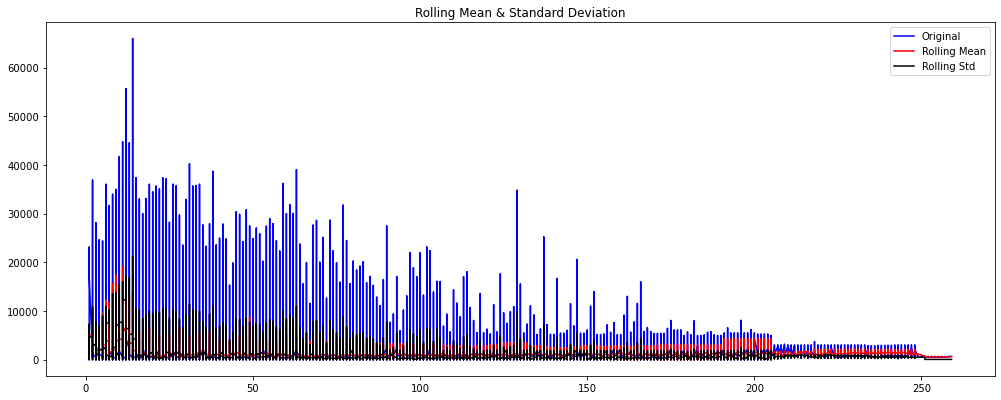

Results of Dickey-Fuller Test:


In [45]:
test_stationarity(abono_dataset["VAL"])

In [46]:
abono_dataset["VAL"]

Meses com abono
1      1638.28
1       566.27
1       579.93
1      3206.31
1       554.47
        ...   
257     685.86
257     594.60
258     543.75
258     685.86
259     685.86
Name: VAL, Length: 4747135, dtype: float64